In [2]:
from controllers import *
%matplotlib widget
p1,p2,p3,p4,p5,p6,p7,p8,p9,p10 = 1e6*np.array([0.0009702344234737915,1.1216300873784233,0.0015283028135708204,1.1220321466763308,0.0000003056064046823101,0.0012133090221050846,1.1216300873784233,0.0019023081463311001,1.1216838484014913,0.00000022497017009016127])
# k_1,k_2,k_3 = 1500898.8475089157, 51911.41903311291, 4.166999999999997
# #E_1,E_2,E_3 = 7.94305039e+04,7.96897538e+04,1.24494237e+05
# Cp1,Cp2 = 1.8097737040262707, 2.6356562630366525

In [3]:
#wipeFolder('Aspen Stuff')

In [4]:
#Process time is 6hr
#Sampling time is 30 seconds
#Integration timestep is 0.3s

netSteps = int(tFinal/delta)
targetTemps = np.array([0, 0])
Kc=np.array([200, 200])
Ki=np.array([0, 0])


# Initail Values
initialValues = np.loadtxt(os.path.join('Aspen Stuff', 'initialValues.txt'), delimiter=",")
C_B1_i   = initialValues[0,0] - C_B1s    # kmol/m3
C_DEB1_i = initialValues[0,1] - C_DEB1s  # kmol/m3
C_E1_i   = initialValues[0,2] - C_E1s    # kmol/m3
C_EB1_i  = initialValues[0,3] - C_EB1s   # kmol/m3
T_1_i    = initialValues[0,4] - T_1s     # K
C_B2_i   = initialValues[1,0] - C_B2s    # kmol/m3
C_DEB2_i = initialValues[1,1] - C_DEB2s  # kmol/m3
C_E2_i   = initialValues[1,2] - C_E2s    # kmol/m3
C_EB2_i  = initialValues[1,3] - C_EB2s   # kmol/m3
T_2_i    = initialValues[1,4] - T_2s     # K

# Initialize the state, control, and error Records
stateRecord = np.zeros((2,5,netSteps+1))
stateRecord[0,0,0] = C_B1_i
stateRecord[0,1,0] = C_DEB1_i
stateRecord[0,2,0] = C_E1_i
stateRecord[0,3,0] = C_EB1_i
stateRecord[0,4,0] = T_1_i
stateRecord[1,0,0] = C_B2_i
stateRecord[1,1,0] = C_DEB2_i
stateRecord[1,2,0] = C_E2_i
stateRecord[1,3,0] = C_EB2_i
stateRecord[1,4,0] = T_2_i

controlRecord = np.zeros((2,netSteps))

errorRecord = [[] for _ in controlRecord]

###########Q Matrices for Cost Function##############
# Qx=np.diag(np.tile([2e3, 1], int(NUM_OUTPUTS/2)))
# Qu=np.diag(np.tile([8e-13, 0.001], int(NUM_OUTPUTS/2)))
loopsPerHour = int(((1.0*60*60)/hcMPC)/controlStepSize)
A1 = np.repeat(10*np.ones(6),loopsPerHour)
A2 = np.repeat(1e-8*np.ones(6),loopsPerHour)
# A1 = np.repeat(10*np.array([1, 0.9, 1.1, 0.8, 1.2, 0.7]),loopsPerHour)
# A2 = np.repeat(1e-8*np.array([1, 0.8 , 1.2, 0.6 , 1.4,0.5]),loopsPerHour)

# Storing the steady state values in 2 arrays
x_ss = np.array([[ C_B1s,C_DEB1s, C_E1s,C_EB1s,  T_1s], [ C_B2s,C_DEB2s,C_E2s, C_EB2s,  T_2s]])
print(f"The steady state values are {x_ss}")

# Transfer the initial values into realtime array, wont store the data permanently, created record lists for that.
currentState = np.array([[ C_B1_i,C_DEB1_i,C_E1_i, C_EB1_i,  T_1_i], [ C_B2_i, C_DEB2_i,C_E2_i, C_EB2_i, T_2_i]])
print(f"The initial values are {currentState}")

The steady state values are [[6.16537275e+00 2.21946483e-07 4.91106659e+00 1.06722948e-01
  3.00000016e+02]
 [5.85350213e+00 1.94907091e-07 4.66398435e+00 9.60759345e-02
  3.00007938e+02]]
The initial values are [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [5]:
Coeff1 = F1/V1
Coeff2 = F1/V2
Coeff3 = F2_new/V2
@njit
def model_makestep(x,u, steps=1, hc=1e-4):
    C_B1,C_DEB1,C_E1,C_EB1,T_1,C_B2,C_DEB2,C_E2,C_EB2,T_2 = x
    Q1,Q2 = u
    for _ in range(steps):
        r1_1  = k_1*math.exp(-E_1/R/(T_1+T_1s))*((C_B1+C_B1s)*(C_E1+C_E1s))
        r1s_1 = k_1*math.exp(-E_1/R/T_1s)*(C_B1s*C_E1s)
        r2_1  = k_2*math.exp(-E_2/R/(T_1+T_1s))*((C_EB1+C_EB1s)*(C_E1+C_E1s))
        r2s_1 = k_2*math.exp(-E_2/R/T_1s)*(C_EB1s*C_E1s)
        r3_1  = k_3*math.exp(-E_3/R/(T_1+T_1s))*((C_B1+C_B1s)*(C_DEB1+C_DEB1s))
        r3s_1 = k_3*math.exp(-E_3/R/T_1s)*(C_B1s*C_DEB1s) 

        r1_2  = k_1*math.exp(-E_1/R/(T_2+T_2s))*((C_B2+C_B2s)*(C_E2+C_E2s))
        r1s_2 = k_1*math.exp(-E_1/R/T_2s)*(C_B2s*C_E2s)
        r2_2  = k_2*math.exp(-E_2/R/(T_2+T_2s))*((C_EB2+C_EB2s)*(C_E2+C_E2s))
        r2s_2 = k_2*math.exp(-E_2/R/T_2s)*(C_EB2s*C_E2s)
        r3_2  = k_3*math.exp(-E_3/R/(T_2+T_2s))*((C_B2+C_B2s)*(C_DEB2+C_DEB2s))
        r3s_2 = k_3*math.exp(-E_3/R/T_2s)*(C_B2s*C_DEB2s)

        C_B1   += hc*(Coeff1*(-C_B1)                            - r1_1 + r1s_1  - r3_1 + r3s_1)
        C_B2   += hc*(Coeff2*(C_B1-C_B2)     + Coeff3*(-C_B2)   - r1_2 + r1s_2  - r3_2 + r3s_2)
        C_DEB1 += hc*(Coeff1*(-C_DEB1)                          + r2_1 - r2s_1 - r3_1 + r3s_1)
        C_DEB2 += hc*(Coeff2*(C_DEB1-C_DEB2) + Coeff3*(-C_DEB2) + r2_2 - r2s_2 - r3_2 + r3s_2)
        C_E1   += hc*(Coeff1*(-C_E1)                            - r1_1 + r1s_1  - r2_1 + r2s_1)
        C_E2   += hc*(Coeff2*(C_E1-C_E2)     + Coeff3*(-C_E2)   - r1_2 + r1s_2  - r2_2 + r2s_2)
        C_EB1  += hc*(Coeff1*(-C_EB1)                           + r1_1 - r1s_1  - r2_1 + r2s_1 + 2*(r3_1-r3s_1))
        C_EB2  += hc*(Coeff2*(C_EB1-C_EB2)   + Coeff3*(-C_EB2)  + r1_2 - r1s_2  - r2_2 + r2s_2 + 2*(r3_2-r3s_2))
        T_1    += hc*(Coeff1*(-T_1)                    - H_1*(r1_1-r1s_1)/(rhoe_L1*Cp1) - H_2*(r2_1-r2s_1)/(rhoe_L1*Cp1)- H_3*(r3_1-r3s_1)/(rhoe_L1*Cp1) +Q1/(rhoe_L1 * Cp1 * V1))
        T_2    += hc*(Coeff2*(T_1-T_2) + Coeff3*(-T_2) - H_1*(r1_2-r1s_2)/(rhoe_L2*Cp2) - H_2*(r2_2-r2s_2)/(rhoe_L2*Cp2)- H_3*(r3_2-r3s_2)/(rhoe_L2*Cp2) +Q2/(rhoe_L2 * Cp2 * V2))
    return np.array([C_B1,C_DEB1,C_E1,C_EB1,T_1,C_B2,C_DEB2,C_E2,C_EB2,T_2])
def eval_f(u):#L=xQx+uRu
    offset = 0
    x = stateRecord[:,:,main_iteration].reshape(-1)
    
    # Assuming the state vector includes all species and temperature for both reactors
    

    # Numerical Integration
    for controlIteration in range(controlTimeStepsPerMPC):
        Q1    = u.item(NUM_U*controlIteration + 0)  # Heat input for reactor 1
        Q2    = u.item(NUM_U*controlIteration + 1)  # Heat input for reactor 2
        
        # Update states for both reactors
        x = model_makestep(x, [Q1,Q2], controlStepSize, hcMPC)
        C_EB2 = x.item(8)
        # Cost calculation:
        # - Minimize consumption of Benzene (B)
        # - Maximize production of Ethylbenzene (EB)
        # - Minimize heat usage (Q^2 for both reactors)
        
        # Concentration of EthylBenzene (B) in last reactor
        finalEthylBenzene = (C_EB2 + C_EB2s)
        
        # Heat usage
        heat_usage = (Q1+Q1s)**2 + (Q2+Q2s)**2
        
         # Cost function components:
        # - Maximize EB production (negative sign because we're minimizing, but we want to maximize this)
        # - Minimize heat usage (positive sign to minimize)
        offset += -A1[main_iteration]*finalEthylBenzene + A2[main_iteration]*heat_usage
    return offset * delta


def eval_g(u):  # V condition, Vdot condition, the Energy constraint
    g = np.array([1.0] * (controlTimeStepsPerMPC))  # Default to >=0 i.e valid
    x = stateRecord[:,:,main_iteration].reshape(-1)
    xss = x_ss.reshape(-1)
    T_1 = x.item(4)
    T_1s = xss.item(4)
    T_2 = x.item(9)
    T_2s = xss.item(9)
    
    bias =  0.000065

    if (T_1/T_1s>0.15 or T_2/T_2s>0.15):#Check if any term is 15% off the steady state value, i.e, the system is not in the economic region
        Q1 = u.item(0)
        Q2 = u.item(1)

        LfV = 0.0
        Lg1V = (2 * p5  * T_1 ) /(rhoe_L1 * Cp1 * V1)
        Lg2V = (2 * p10 * T_2 ) /(rhoe_L2 * Cp2 * V2)
        dV_op2 = LfV + Lg1V * Q1 + Lg2V * Q2  # (EMPC)Vdot = LfV(x)+LgV(x)*u
        
        u11 = Kc.item(0) * (0.0 - T_1)
        u22 = Kc.item(1) * (0.0 - T_2)
        dV_Pu2 = LfV + Lg1V * u11 + Lg2V * u22  # (PI)Vdot = LfV(x)+LgV(x)*u
        g[:] = min(0.0, dV_Pu2 - bias) - dV_op2 # Ensure we perform better than the Reference Controller
    else:
        for controlIteration in range(controlTimeStepsPerMPC):
            Q1   = u.item(NUM_U * controlIteration + 0)
            Q2   = u.item(NUM_U * controlIteration + 1)
            x = model_makestep(x,[Q1,Q2],controlStepSize,hcMPC)
            g[controlIteration] = 0.3 - abs(x.item(4)/x_ss.item(4)) - abs(x.item(9)/x_ss.item(9)) # Ensure we stay in the economic region
    #print(g)
    return g  # f(x) + C >= 0
cons = [
    #{"type": "eq", "fun": equalityConstraints},
    #{"type": "ineq", "fun": eval_g, "jac": eval_jac_g},
    {"type": "ineq", "fun": eval_g},
]

u_L = []
u_U = []
lowerBounds = [-1e4,-1.5e4]
upperBounds = [5e4,5e4]#e3
for _ in range(controlTimeStepsPerMPC):
    u_L = u_L + lowerBounds
    u_U = u_U + upperBounds
bnds = [(u_L[_], u_U[_]) for _ in range(NUM_MPC_INPUTS)]

In [6]:
wipeFolder('Aspen Stuff')
#Transfer the initial values into realtime array, wont store the data permanently, created record lists for that. 
inputFile = os.path.join('Aspen Stuff', 'u.txt')
start_time = time.time()
for main_iteration in range(netSteps):
    print("\n\n\n")
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print("Iteration #", main_iteration + 1)
    print(f"Current State Variable Values: x = {stateRecord[:,:,main_iteration].reshape(-1)}")
    print("Current V Value: ", np.dot(stateRecord[:,:,main_iteration].reshape(-1),np.dot(np.diag([p1,p2,p3,p4,p5,p6,p7,p8,p9,p10]),stateRecord[:,:,main_iteration].reshape(-1))))
    print("Outside economic region:",np.any(stateRecord[:,-1,main_iteration].reshape(-1)/x_ss[:,-1].reshape(-1)>0.15))
    print("Outside stability region:",np.any(stateRecord[:,-1,main_iteration].reshape(-1)/x_ss[:,-1].reshape(-1)>0.2))
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    
    if main_iteration == 0:
        uUnoptimized = np.array([0.0] * NUM_MPC_INPUTS)  # which are u1 and u2 [Initialize blank array]
    else:
        #uUnoptimized = np.array([0.0] * NUM_MPC_INPUTS)
        uUnoptimized = u
        # Shift control inputs over 1 horizon(Last horizon is duplicated, but this is ok as we only sample and hold for 1 horizon)
        uUnoptimized[0:-NUM_U] = u[NUM_U:]
    
    print("Solving IPOPT...")
    start_time_IPOPT = time.time()
    soln = minimize_ipopt(
        eval_f,
        #jac=eval_grad_f,
        x0=uUnoptimized,
        bounds=bnds,
        constraints=cons,
        #options={"maxiter": 10000, "tol": 1e-4,"eps": 1e-3},
        options={"maxiter": 100, "tol": 1e-3,"print_level": 5,'check_derivatives_for_naninf':'yes','eps':1e-6},
    )
    end_time_IPOPT = time.time()
    total_runtime_IPOPT = end_time_IPOPT - start_time_IPOPT
    objectiveValue = soln.info['obj_val']
    constraintResults = (soln.info['g']).reshape(-1,1)
    solverStatus = soln.status
    print("Total time required to solve via IPOPT = %f seconds " % total_runtime_IPOPT)
    print("IPOPT Closed.")
    print("Objective Value:",objectiveValue)
    print("Constraints:", constraintResults.reshape(1,-1))
    print("Solve Status:",solverStatus)
    print("Number of Iterations:",soln.nit)
    print(soln.message.decode('utf-8'))

    # Print IPOPT Results
    if solverStatus==-1:
        u = soln.x
        uNew = solvePI(T=stateRecord[:,-1,main_iteration],
                T_setpoint=targetTemps,
                Kc=Kc,
                Ki=Ki,
                PIcontrolStepSize=PIcontrolStepSize,
                hc=hcPI,
                lowerBounds = lowerBounds,
                upperBounds = upperBounds,
                errorRecord = errorRecord,
                encrypted = False, 
                isArray = True)
        u[0:NUM_U] = uNew
    else:
        u = soln.x
    print("Optimized u values are:", u)

    # Define the initial values of the Control Variables
    controlRecord[0][main_iteration] =  u.item(0)
    controlRecord[1][main_iteration] =  u.item(1)
    np.savetxt(inputFile, [u.item(0)+Q1s,u.item(1)+Q2s], fmt ='%.5f')
    open(os.path.join('Aspen Stuff', 'greenLightAspen'), 'w').close()

    # Load data from Aspen
    file = os.path.join('Aspen Stuff', 'greenLightPython')
    print(f"Waiting for Aspen to send data...(Iteration #{main_iteration+1})",end='\r')
    while not os.path.isfile(file):
        pass
    print(f"Aspen Data found.",end='\r')
    dynamicData =np.loadtxt(os.path.join('Aspen Stuff', 'dynamicValues.txt'), delimiter = ",")
    while os.path.isfile(file):
        try:
            os.remove(file)
        except PermissionError:
            pass
    stateRecord[:,:,main_iteration+1] = dynamicData - x_ss
end_time = time.time()

total_runtime = end_time - start_time
print("Total time required to execute the code = %f seconds " % total_runtime)

File does not exist: c:\Users\arthu\JupyterNotebook\Code\MPC\Aspen\Aspen Stuff\greenLightAspen
File does not exist: c:\Users\arthu\JupyterNotebook\Code\MPC\Aspen\Aspen Stuff\greenLightPython
File does not exist: c:\Users\arthu\JupyterNotebook\Code\MPC\Aspen\Aspen Stuff\u.txt
Deleted: c:\Users\arthu\JupyterNotebook\Code\MPC\Aspen\Aspen Stuff\dynamicValues.txt
File deletion process completed.




%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Iteration # 1
Current State Variable Values: x = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Current V Value:  0.0
Outside economic region: False
Outside stability region: False
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Solving IPOPT...
Total time required to solve via IPOPT = 3.589345 seconds 
IPOPT Closed.
Objective Value: -293.21816913453193
Constraints: [[0.28971589 0.27998067 0.27090646 0.26249018 0.25472366 0.24756744
  0.24094879 0.23476406 0.22894586 0.22330252]]
Solve Status: 0
Number of Iterations: 11
Algorithm terminated successfully at a locally optimal point, satisfying the co

KeyboardInterrupt: 

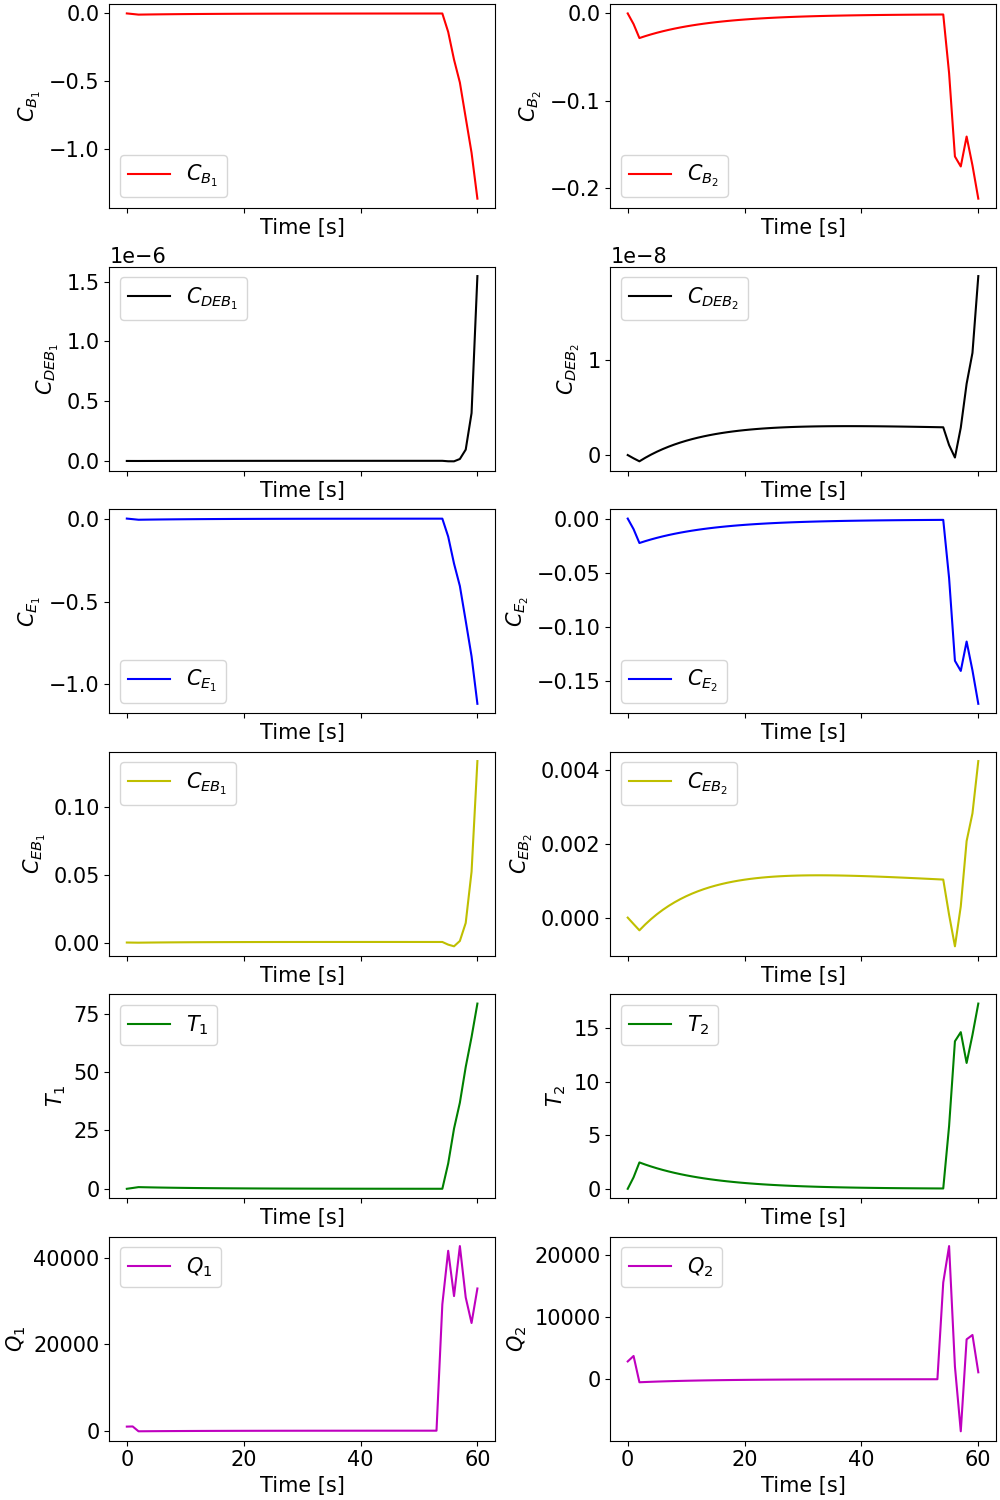

In [7]:
plt.rcParams['font.size'] = 15
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts
plt.rcParams['ps.fonttype'] = 42   # Also for PostScript outputs
plt.rcParams['text.usetex'] = False
plt.gcf().align_ylabels()
plt.close('all')
fig = plt.figure(figsize = (10,15))
grid = fig.add_gridspec(6,2,hspace = 0)
axes = grid.subplots(sharex=True,sharey=False)

#Plotting the results
colors = ['r', 'k', 'b', 'y', 'g','m']
labels = ['C_{B', 'C_{DEB', 'C_{E', 'C_{EB', 'T','Q']

for i in range(6):
    for j in range(2):
        if i<4:
            latex_label = f"${labels[i]}_{{{j+1}}}}}$"
        else:
            latex_label = f"${labels[i]}_{{{j+1}}}$"
        if i==5:
            axes[i,j].plot(controlRecord[j,:61],colors[i],label=latex_label)
        else:    
            axes[i,j].plot(stateRecord[j,i,:61],colors[i],label=latex_label)
        axes[i,j].set_xlabel('Time [s]')
        axes[i,j].set_ylabel(latex_label)
        axes[i,j].legend()
# Adjust the layout so plots do not overlap
#plt.tight_layout()
plt.show()

In [203]:
stateRecord[:,:,0]

array([[ 9.79501572e-05, -2.19607104e-10,  7.82788722e-05,
         3.83342881e-07, -9.98303517e-04],
       [-3.24566921e-05,  2.82321639e-06, -1.23069820e-04,
         4.68729925e-04,  1.47272255e-02]])

In [204]:
#Saving the results to text files
stateNames = ['C_B_1_record', 'C_DEB_1_record', 'C_E_1_record', 'C_EB_1_record', 'T_1_record', 'C_B_2_record', 'C_DEB_2_record', 'C_E_2_record', 'C_EB_2_record', 'T_2_record']
controlNames = ['Q_1_record', 'Q_2_record']
for i, name in enumerate(stateNames):
    file = os.path.join('Results_MPCcontrol', f'{name}.txt')
    np.savetxt(file, stateRecord[i//5,i%5,:])
for i, name in enumerate(controlNames):
    file = os.path.join('Results_MPCcontrol', f'{name}.txt')
    np.savetxt(file, controlRecord[i,:])
file = os.path.join('Results_MPCcontrol', 'finalIteration.txt')
np.savetxt(file, currentState)

### ODE and parameters
The elementary reactions are:
\begin{gather}
B+E\rightarrow EB\\
E+EB\rightarrow DEB\\
B+DEB\rightarrow 2*EB\\
\end{gather}
Which yields the following power laws:
\begin{gather}
r_1=k_1\exp\left(\frac{-E_1}{RT}\right)C_BC_E\\
r_2=k_2\exp\left(\frac{-E_2}{RT}\right)C_EC_{EB}\\
r_3=k_3\exp\left(\frac{-E_3}{RT}\right)C_{EB}C_{DEB}\\
\end{gather}
The system model is described by the ordinary differential equation:
\begin{align*}
\dot{C}_{B,1} &= \frac{F_1}{V_1}(C_{B,0} - C_{B,1}) - k_0\exp\left(\frac{-E_A}{RT}\right)C_{B,1}^2\\
\dot{C}_{B,1} &= \frac{F_1}{V_1}(C_{B,0} - C_{B,1}) - k_0\exp\left(\frac{-E_A}{RT}\right)C_{B,1}^2\\
\dot{C}_{B,1} &= \frac{F_1}{V_1}(C_{B,0} - C_{B,1}) - k_0\exp\left(\frac{-E_A}{RT}\right)C_{B,1}^2\\
\dot{C}_{B,1} &= \frac{F_1}{V_1}(C_{B,0} - C_{B,1}) - k_0\exp\left(\frac{-E_A}{RT}\right)C_{B,1}^2\\
\dot{T} &= \frac{F}{V}(T_0-T)-\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{RT}\right)}{\rho_L{C_P}}C_A^2+\frac{\dot{Q}}{\rho_LC_PV}\\
\end{align*}
For simplicity, we work with deviation variables and thus we subtract the steady state values for these ODEs
\begin{align*}
\dot{C}_{A_s} &= \frac{F}{V}(C_{{A,0}_s} - C_{A_s}) - k_0\exp\left(\frac{-E_A}{RT_s}\right)C_{A_s}^2\\
\dot{T_s} &= \frac{F}{V}(T_{0_s}-T_s)-\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{RT_s}\right)}{\rho_L{C_P}}C_{A_s}^2+\frac{\dot{Q_s}}{\rho_LC_PV}\\
\end{align*}
Which results in our final expressions:
\begin{align*}
\dot{\bar{C}}_A &= \frac{F}{V}(\bar{C}_{A,0} - \bar{C}_{A}) - k_0\exp\left(\frac{-E_A}{R(\bar{T}+T_s)}\right)(\bar{C}_A+C_{A_s})^2 + k_0\exp\left(\frac{-E_A}{RT_s}\right)C_{A_s}^2\\
\dot{\bar{T}} &= \frac{F}{V}(\bar{T}_0-\bar{T})-\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{R(\bar{T}+T_s)}\right)}{\rho_L{C_P}}(\bar{C}_A+C_{A_s})^2+\frac{\Delta{H}k_0\exp\left(\frac{-E_A}{RT_s}\right)}{\rho_L{C_P}}C_{A_s}^2+\frac{\dot{\bar{Q}}}{\rho_LC_PV}\\
\text{State-Variables}&=\begin{cases}
\bar{C}_A &= C_A - C_{A_s} \\
\bar{T} &= T - T_s \\
\end{cases}\\
\text{Control-Variables}&=\begin{cases}
\bar{C}_{A,0} &= C_{A,0} - C_{A_s,0} \\
\bar{Q} &= Q - Q_s \\
\end{cases}\\
\text{Redefined-Constants}&=\begin{cases}
\bar{T}_0 &= T_0 - T_{0,s} \\
\end{cases}\\
\text{Constants}&=\begin{cases}
R &= 8.314\frac{kJ}{kmol-K} \\
F_1 &= 43.35650368560001\frac{m^3}{hr} \\
V_1 &= 60m^3 \\
F_2 &= 43.37565994439999\frac{m^3}{hr} \\
V_2 &= 60m^3 \\
\rho_{L_1} &= 640.695\frac{kg}{m^3} \\
\rho_{L_2} &= 608.734\frac{kg}{m^3} \\
\Delta{H}_1 &= -114.13\frac{kJ}{mol} \\
\Delta{H}_2 &= -112.56\frac{kJ}{mol} \\
\Delta{H}_3 &= -1.57\frac{kJ}{mol} \\
E_1 &= 16.9963\frac{kcal}{mol} \\
E_2 &= 19.9866\frac{kcal}{mol} \\
E_3 &= 14.99\frac{kcal}{mol} \\
k_1 &= 1.528\times{10^6}\frac{m^3}{kmol-s} \\
k_2 &= 27780\frac{m^3}{kmol-s} \\
k_3 &= 0.4167\frac{m^3}{kmol-s} \\
C_{B_s,1} &= 4.25817 \frac{kmol}{m^3} \\
C_{DEB_s,1} &= 0 \frac{kmol}{m^3} \\
C_{E_s,1} &= 3.04155 \frac{kmol}{m^3} \\
C_{EB_s,1} &= 0.020277 \frac{kmol}{m^3} \\
C_{B_s,2} &= 1.74496 \frac{kmol}{m^3} \\
C_{DEB_s,2} &= 0 \frac{kmol}{m^3} \\
C_{E_s,2} &= 0.558386 \frac{kmol}{m^3} \\
C_{EB_s,2} &= 1.1633 \frac{kmol}{m^3} \\
T_{s,1} &= 321.154K \\
T_{s,2} &= 442.9880212435662K \\
Q_{s,1} &= -1074.63 \frac{kJ}{s} \\
Q_{s,2} &= -6768.83 \frac{kJ}{s} \\
C_{{B_s,1}_i} &= 5.53823 \frac{kmol}{m^3} \\
C_{{DEB_s,1}_i} &= 0 \frac{kmol}{m^3} \\
C_{{E_s,1}_i} &= 4.43068 \frac{kmol}{m^3} \\
C_{{EB_s,1}_i} &= 0 \frac{kmol}{m^3} \\
C_{{B_s,2}_i} &= 5.01953 \frac{kmol}{m^3} \\
C_{{DEB_s,2}_i} &= 0 \frac{kmol}{m^3} \\
C_{{E_s,2}_i} &= 4.0162 \frac{kmol}{m^3} \\
C_{{EB_s,2}_i} &= 0 \frac{kmol}{m^3} \\
T_{1_i} &= 350K \\
T_{{1_s}_i} &= 350K \\
T_{2_i} &= 350K \\
T_{{2_s}_i} &= 350K \\
\end{cases}
\end{align*}

All that remains is to define the initial values of the State-Variables in Deviation form, but this is up to the user to decide on values.

In [5]:
import numpy as np
import os
file = os.path.join('Results_MPCcontrol', 'test.txt')
test=np.empty((1,1))
np.savetxt(file, test)